In [16]:
import pandas as pd

def load_dataset():
  column_names = [
      "srcip", "sport", "dstip", "dsport", "proto", "state", "dur", "sbytes", "dbytes", "sttl", "dttl",
      "sloss", "dloss", "service", "Sload", "Dload", "Spkts", "Dpkts", "swin", "dwin", "stcpb", "dtcpb",
      "smeansz", "dmeansz", "trans_depth", "res_bdy_len", "Sjit", "Djit", "Stime", "Ltime", "Sintpkt",
      "Dintpkt", "tcprtt", "synack", "ackdat", "is_sm_ips_ports", "ct_state_ttl", "ct_flw_http_mthd",
      "is_ftp_login", "ct_ftp_cmd", "ct_srv_src", "ct_srv_dst", "ct_dst_ltm", "ct_src_ltm",
      "ct_src_dport_ltm", "ct_dst_sport_ltm", "ct_dst_src_ltm", "attack_cat", "Label"
  ]

  df1 = pd.read_csv("DS_term/UNSW-NB15_1.csv", header=None, names=column_names, low_memory=False)
  df2 = pd.read_csv("DS_term/UNSW-NB15_2.csv", header=None, names=column_names, low_memory=False)
  df3 = pd.read_csv("DS_term/UNSW-NB15_3.csv", header=None, names=column_names, low_memory=False)
  df4 = pd.read_csv("DS_term/UNSW-NB15_4.csv", header=None, names=column_names, low_memory=False)

  df1_0 = df1[df1['Label'] == 0]
  df2_0 = df2[df2['Label'] == 0]
  df3_0 = df3[df3['Label'] == 0]
  df4_0 = df4[df4['Label'] == 0]

  df1_1 = df1[df1['Label'] == 1]
  df2_1 = df2[df2['Label'] == 1]
  df3_1 = df3[df3['Label'] == 1]
  df4_1 = df4[df4['Label'] == 1]

  df_label0 = pd.concat([df1_0, df2_0, df3_0, df4_0], ignore_index=True)
  df_label1 = pd.concat([df1_1, df2_1, df3_1, df4_1], ignore_index=True)


  df_label1 = df_label1[df_label1['attack_cat'].isin(["Generic", "Reconnaissance"])]
  df_label0 = df_label0.sample(frac=0.25)

  df_final = pd.concat([df_label0, df_label1])
  df_final = df_final.drop('attack_cat', axis=1)

  df_final.to_csv("DS_term/1_Raw_DataSet.csv", index=False)

if __name__ == '__main__':
  load_dataset()

데이터 로딩 중...
원본 훈련 데이터 크기: (540351, 48)
원본 테스트 데이터 크기: (231580, 48)
--------------------------------------------------
훈련 데이터의 결측값:
ct_flw_http_mthd    330665
is_ftp_login        343621
dtype: int64
-----
훈련 데이터 ct_ftp_cmd 처리 결과:
<IntegerArray>
[0, 1, 6, 4, 2, 3, 5, 8]
Length: 8, dtype: Int64
688171    0
357229    0
757635    0
435669    0
574974    0
547405    0
383679    0
368830    0
475425    0
510987    0
Name: ct_ftp_cmd, dtype: Int64
Int64
훈련 데이터 원본: 540351
테스트 데이터 원본: 231580
훈련 데이터 중복: 153467
테스트 데이터 중복: 52321

이상치 처리 기준 (훈련 데이터 기준):
훈련 데이터 이상치 제거: 0개

=== 데이터 클리닝 완료 ===
훈련 데이터: 540351 → 386884 (71.6% 유지)
테스트 데이터: 231580 → 179259 (77.4% 유지)


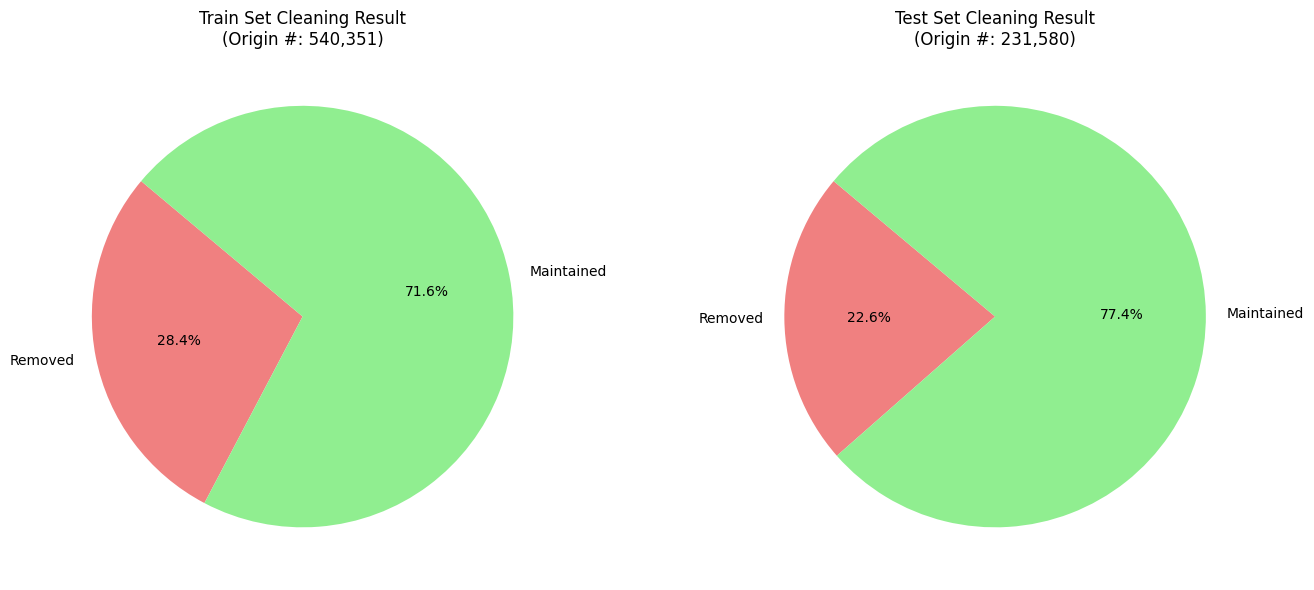


클리닝 완료!
정제된 훈련 데이터 크기: (386884, 42)
정제된 테스트 데이터 크기: (179259, 42)


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.model_selection import train_test_split

def data_cleaning(df_train, df_test, is_plot=False):
    # 원본 데이터 보존을 위한 복사본 생성
    df_train_clean = df_train.copy()
    df_test_clean = df_test.copy()

    # 결측값 분석 (훈련 데이터 기준)
    null_counts = df_train_clean.isnull().sum()
    print("훈련 데이터의 결측값:")
    print(null_counts[null_counts > 0])

    # 1. 결측값 처리 - 동일한 방식으로 양쪽 데이터에 적용
    def handle_missing_values(df):
        df['ct_flw_http_mthd'] = df['ct_flw_http_mthd'].fillna(0).astype(np.uint8)
        df['is_ftp_login'] = df['is_ftp_login'].fillna(0).astype(np.uint8)
        df.replace({'ct_ftp_cmd': {' ': np.nan}}, regex=True, inplace=True)
        df['ct_ftp_cmd'] = pd.to_numeric(df['ct_ftp_cmd'], errors='coerce')
        df['ct_ftp_cmd'] = df['ct_ftp_cmd'].fillna(0).astype('Int64')
        return df

    df_train_clean = handle_missing_values(df_train_clean)
    df_test_clean = handle_missing_values(df_test_clean)

    print("-----")
    print("훈련 데이터 ct_ftp_cmd 처리 결과:")
    print(df_train_clean['ct_ftp_cmd'].unique())
    print(df_train_clean['ct_ftp_cmd'].head(10))
    print(df_train_clean['ct_ftp_cmd'].dtype)

    # 2. 데이터 개수 기록
    original_train_count = df_train_clean.shape[0]
    original_test_count = df_test_clean.shape[0]
    print(f"훈련 데이터 원본: {original_train_count}")
    print(f"테스트 데이터 원본: {original_test_count}")

    # 3. 중복 데이터 제거
    train_duplicates = df_train_clean.duplicated().sum()
    test_duplicates = df_test_clean.duplicated().sum()
    print(f"훈련 데이터 중복: {train_duplicates}")
    print(f"테스트 데이터 중복: {test_duplicates}")

    df_train_clean = df_train_clean.drop_duplicates()
    df_test_clean = df_test_clean.drop_duplicates()

    # 4. 이진 컬럼 타입 최적화 - 양쪽 데이터에 적용
    def optimize_binary_columns(df):
        for col in df.columns:
            unique_vals = df[col].dropna().unique()
            if set(unique_vals).issubset({0, 1}):
                df[col] = df[col].astype(np.uint8)
        return df

    df_train_clean = optimize_binary_columns(df_train_clean)
    df_test_clean = optimize_binary_columns(df_test_clean)

    # 5. 이상치 처리 - 훈련 데이터에서 기준 계산, 양쪽에 적용
    # outlier_cols = ['tcprtt', 'synack', 'ackdat']
    outlier_cols = []
    outlier_stats = {}

    print("\n이상치 처리 기준 (훈련 데이터 기준):")
    for col in outlier_cols:
        if col in df_train_clean.columns:
            q1 = df_train_clean[col].quantile(0.25)
            q3 = df_train_clean[col].quantile(0.75)
            iqr = q3 - q1
            lower = q1 - 1.5 * iqr
            upper = q3 + 1.5 * iqr

            outlier_stats[col] = {'lower': lower, 'upper': upper}
            print(f"{col}: [{lower:.2f}, {upper:.2f}]")

    # 이상치 제거 적용
    train_before_outlier = df_train_clean.shape[0]

    for col, bounds in outlier_stats.items():
        if col in df_train_clean.columns:
            df_train_clean = df_train_clean[
                (df_train_clean[col] >= bounds['lower']) &
                (df_train_clean[col] <= bounds['upper'])
            ]

    train_outliers_removed = train_before_outlier - df_train_clean.shape[0]

    print(f"훈련 데이터 이상치 제거: {train_outliers_removed}개")

    # 6. 불필요한 컬럼 제거
    columns_to_drop = ['srcip', 'dstip', 'Stime', 'Ltime', 'stcpb', 'dtcpb']
    df_train_clean = df_train_clean.drop(columns=columns_to_drop, errors='ignore')
    df_test_clean = df_test_clean.drop(columns=columns_to_drop, errors='ignore')

    # 7. 최종 결과 출력
    final_train_count = df_train_clean.shape[0]
    final_test_count = df_test_clean.shape[0]

    print(f"\n=== 데이터 클리닝 완료 ===")
    print(f"훈련 데이터: {original_train_count} → {final_train_count} "
          f"({final_train_count/original_train_count*100:.1f}% 유지)")
    print(f"테스트 데이터: {original_test_count} → {final_test_count} "
          f"({final_test_count/original_test_count*100:.1f}% 유지)")

    # 8. 시각화 (선택사항)
    if is_plot:
        create_cleaning_plot(original_train_count, final_train_count,
                           original_test_count, final_test_count,
                           train_duplicates + train_outliers_removed,
                           test_duplicates)

    return df_train_clean, df_test_clean


def create_cleaning_plot(orig_train, final_train, orig_test, final_test, train_removed, test_removed):
    """데이터 클리닝 결과를 시각화하는 함수"""

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # 훈련 데이터 변화
    train_labels = ['Removed', 'Maintained']
    train_sizes = [train_removed, final_train]
    colors = ['lightcoral', 'lightgreen']

    ax1.pie(train_sizes, labels=train_labels, colors=colors,
            autopct='%1.1f%%', startangle=140)
    ax1.set_title(f'Train Set Cleaning Result\n(Origin #: {orig_train:,})')

    # 테스트 데이터 변화
    test_labels = ['Removed', 'Maintained']
    test_sizes = [test_removed, final_test]

    ax2.pie(test_sizes, labels=test_labels, colors=colors,
            autopct='%1.1f%%', startangle=140)
    ax2.set_title(f'Test Set Cleaning Result\n(Origin #: {orig_test:,})')

    plt.tight_layout()
    plt.show()


# 메인 실행 코드
if __name__ == "__main__":
    # 데이터 로드
    print("데이터 로딩 중...")
    df = pd.read_csv("DS_term/1_Raw_DataSet.csv", low_memory=False)

    df_train, df_test = train_test_split(
        df,
        test_size = 0.3,
        shuffle = True,
        random_state = 42,
        stratify = df['Label']
    )

    print(f"원본 훈련 데이터 크기: {df_train.shape}")
    print(f"원본 테스트 데이터 크기: {df_test.shape}")
    print("-" * 50)

    # 데이터 클리닝 실행
    df_train_clean, df_test_clean = data_cleaning(df_train, df_test, is_plot=True)

    # 결과 확인
    print("\n클리닝 완료!")
    print(f"정제된 훈련 데이터 크기: {df_train_clean.shape}")
    print(f"정제된 테스트 데이터 크기: {df_test_clean.shape}")

    # 파일 저장
    df_train_clean.to_csv("DS_term/2_Cleaning_DataSet.csv", index=False)
    df_test_clean.to_csv("DS_term/2_Cleaning_TestDataSet.csv", index=False)

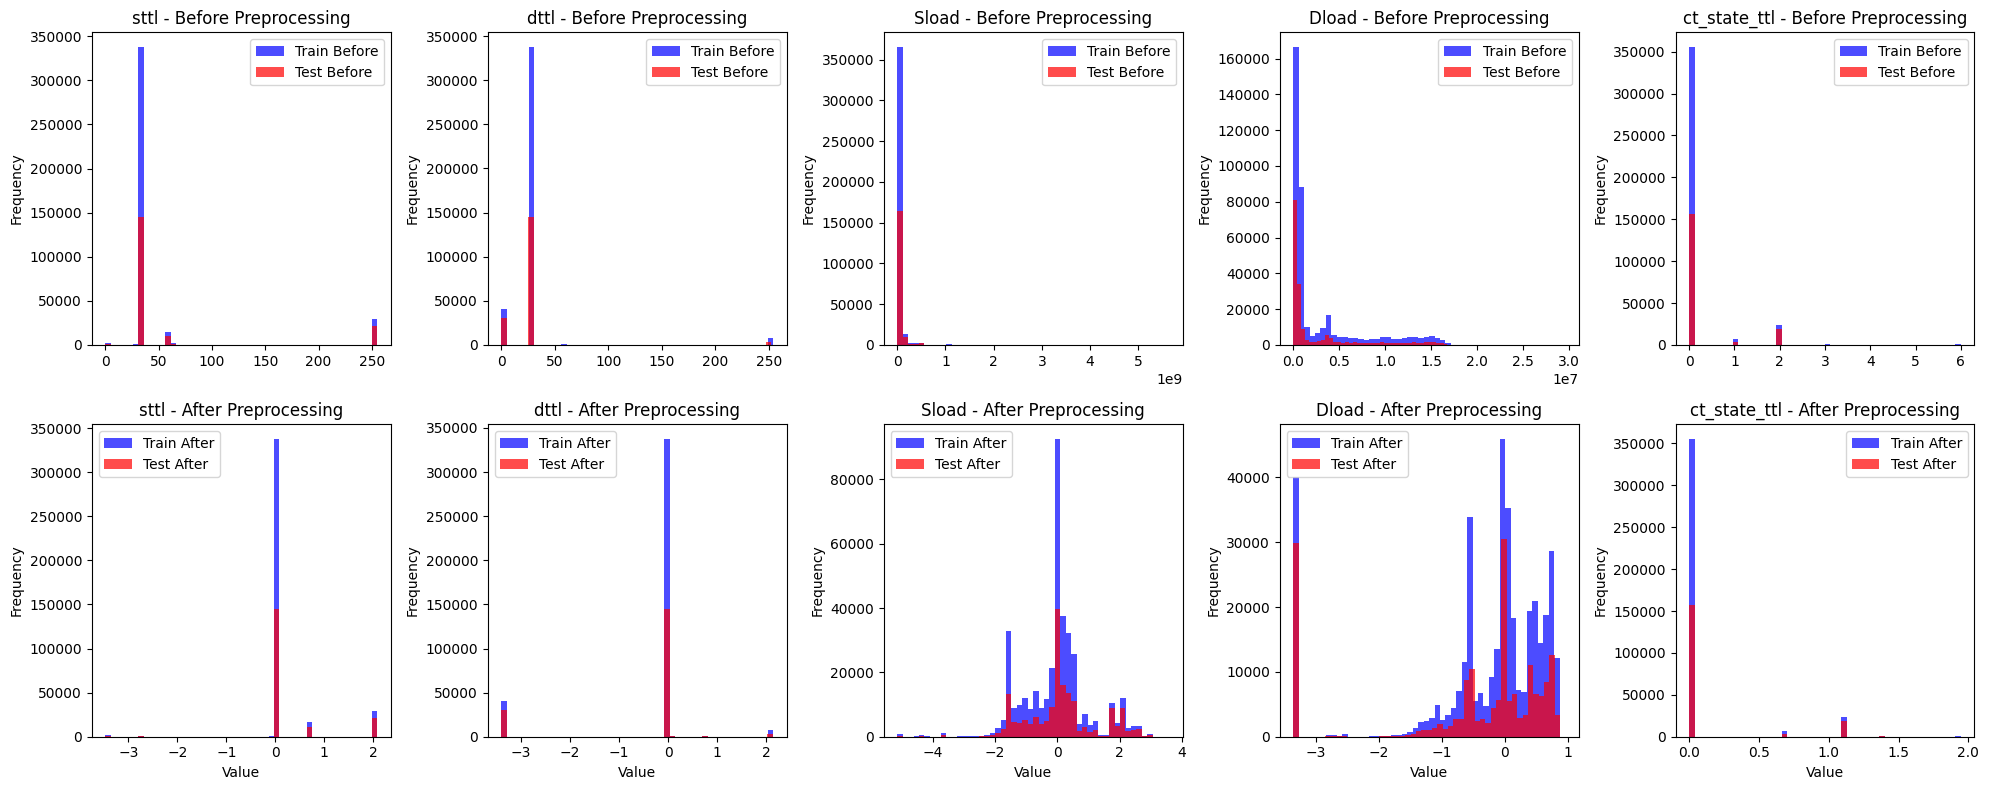

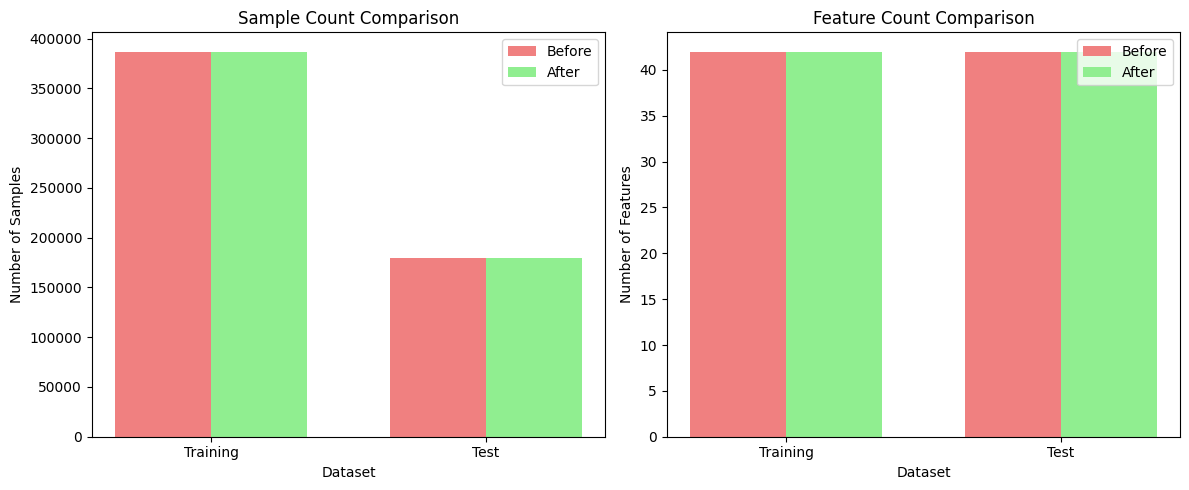

컬럼 변동 (train) : set()
컬럼 변동 (test) : set()
전처리 완료 및 결과 저장됨


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler, StandardScaler
import seaborn as sns
import pickle
import os
from typing import Tuple, Dict, Any


import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler, StandardScaler


class CustomPreprocessor:
    def __init__(self):
        self.log_cols = [
            'dur', 'sbytes', 'dbytes', 'sttl', 'dttl', 'sloss', 'dloss',
            'Sload', 'Dload', 'Spkts', 'Dpkts', 'swin', 'dwin',
            'smeansz', 'dmeansz', 'trans_depth', 'res_bdy_len', 'Sjit', 'Djit',
            'Sintpkt', 'Dintpkt', 'ct_state_ttl', 'ct_flw_http_mthd', 'ct_ftp_cmd',
            'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ltm', 'ct_dst_src_ltm'
        ]
        self.standard_cols = ['tcprtt', 'synack', 'ackdat']
        self.exclude_cols = ['Label', 'sport', 'dsport']

        self.robust_scaler = None
        self.standard_scaler = None
        self.fitted_log_cols = None
        self.fitted_standard_cols = None
        self.fitted_categorical_cols = None
        self.final_columns = None
        self.fitted = False

    def fit(self, X):
        """훈련 데이터로 변환 파라미터 학습"""

        # dsport 컬럼 형변환
        if 'dsport' in X.columns:
          X['dsport'] = pd.to_numeric(X['dsport'], errors='coerce').fillna(0)

        if 'sport' in X.columns:
          X['sport'] = pd.to_numeric(X['sport'], errors='coerce').fillna(0)

        # 실제 존재하는 컬럼만 선택
        self.fitted_log_cols = [col for col in self.log_cols if col in X.columns]
        self.fitted_standard_cols = [col for col in self.standard_cols if col in X.columns]

        # 범주형 컬럼 자동 감지
        categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
        self.fitted_categorical_cols = [col for col in categorical_cols if col not in self.exclude_cols]

        # 로그 변환 적용
        X_log = self._apply_log_transform(X)

        # 스케일러 학습
        if self.fitted_log_cols:
            self.robust_scaler = RobustScaler()
            self.robust_scaler.fit(X_log[self.fitted_log_cols])

        if self.fitted_standard_cols:
            self.standard_scaler = StandardScaler()
            self.standard_scaler.fit(X_log[self.fitted_standard_cols])

        # 최종 컬럼 구조 파악
        self.final_columns = X.columns

        self.fitted = True
        return self

    def transform(self, X):
        """학습된 파라미터로 데이터 변환"""
        if not self.fitted:
            raise ValueError("fit() 먼저 호출 필요")

        X_transformed = X.copy()

        # 로그 변환
        X_transformed = self._apply_log_transform(X_transformed)

        # 스케일링
        if self.robust_scaler and self.fitted_log_cols:
            available_cols = [col for col in self.fitted_log_cols if col in X_transformed.columns]
            if available_cols:
                X_transformed[available_cols] = self.robust_scaler.transform(X_transformed[available_cols])

        if self.standard_scaler and self.fitted_standard_cols:
            available_cols = [col for col in self.fitted_standard_cols if col in X_transformed.columns]
            if available_cols:
                X_transformed[available_cols] = self.standard_scaler.transform(X_transformed[available_cols])

        # 원핫 인코딩
        X_transformed = self._apply_one_hot_encoding(X_transformed)

        # 컬럼 일관성 보장
        for col in self.final_columns:
            if col not in X_transformed.columns:
                X_transformed[col] = 0

        return X_transformed[self.final_columns]

    def fit_transform(self, X):
        """fit과 transform을 연속 수행"""
        return self.fit(X).transform(X)

    def _apply_log_transform(self, X):
        """로그 변환 적용"""
        X_copy = X.copy()
        for col in self.fitted_log_cols or []:
            if col in X_copy.columns:
                X_copy[col] = np.log1p(np.maximum(X_copy[col], 0))
        return X_copy

    def _apply_one_hot_encoding(self, X):
        """원핫 인코딩 적용"""
        if not self.fitted_categorical_cols:
            return X

        available_cols = [col for col in self.fitted_categorical_cols if col in X.columns]
        if available_cols:
            return pd.get_dummies(X, columns=available_cols, prefix=available_cols)
        return X



def visualize_results(train_before, train_after, test_before, test_after, sample_columns):
    """전처리 결과 시각화"""

    if not sample_columns:
        print("시각화할 컬럼이 없습니다.")
        return

    fig, axes = plt.subplots(2, len(sample_columns), figsize=(4*len(sample_columns), 8))
    if len(sample_columns) == 1:
        axes = axes.reshape(-1, 1)

    for i, col in enumerate(sample_columns):
        if col in train_before.columns and col in train_after.columns:
            # 전처리 전
            axes[0, i].hist(train_before[col].dropna(), bins=50, alpha=0.7,
                           label='Train Before', color='blue')
            axes[0, i].hist(test_before[col].dropna(), bins=50, alpha=0.7,
                           label='Test Before', color='red')
            axes[0, i].set_title(f'{col} - Before Preprocessing')
            axes[0, i].legend()
            axes[0, i].set_ylabel('Frequency')

            # 전처리 후
            axes[1, i].hist(train_after[col].dropna(), bins=50, alpha=0.7,
                           label='Train After', color='blue')
            axes[1, i].hist(test_after[col].dropna(), bins=50, alpha=0.7,
                           label='Test After', color='red')
            axes[1, i].set_title(f'{col} - After Preprocessing')
            axes[1, i].legend()
            axes[1, i].set_ylabel('Frequency')
            axes[1, i].set_xlabel('Value')

    plt.tight_layout()
    plt.show()

    # 데이터 형태 변화 시각화
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # 데이터 크기 변화
    categories = ['Training', 'Test']
    before_counts = [train_before.shape[0], test_before.shape[0]]
    after_counts = [train_after.shape[0], test_after.shape[0]]

    x = np.arange(len(categories))
    width = 0.35

    ax1.bar(x - width/2, before_counts, width, label='Before', color='lightcoral')
    ax1.bar(x + width/2, after_counts, width, label='After', color='lightgreen')
    ax1.set_xlabel('Dataset')
    ax1.set_ylabel('Number of Samples')
    ax1.set_title('Sample Count Comparison')
    ax1.set_xticks(x)
    ax1.set_xticklabels(categories)
    ax1.legend()

    # 컬럼 수 변화
    before_cols = [train_before.shape[1], test_before.shape[1]]
    after_cols = [train_after.shape[1], test_after.shape[1]]

    ax2.bar(x - width/2, before_cols, width, label='Before', color='lightcoral')
    ax2.bar(x + width/2, after_cols, width, label='After', color='lightgreen')
    ax2.set_xlabel('Dataset')
    ax2.set_ylabel('Number of Features')
    ax2.set_title('Feature Count Comparison')
    ax2.set_xticks(x)
    ax2.set_xticklabels(categories)
    ax2.legend()

    plt.tight_layout()
    plt.show()


# 실행 예제
if __name__ == "__main__":
    # 데이터 로드
    train_data = pd.read_csv("DS_term/2_Cleaning_DataSet.csv", low_memory=False)
    test_data = pd.read_csv("DS_term/2_Cleaning_TestDataSet.csv", low_memory=False)

    # 전처리 수행
    preprocessor = CustomPreprocessor()
    train_processed = preprocessor.fit_transform(train_data)
    test_processed = preprocessor.transform(test_data)

    # 결과 시각화
    visualize_results(train_data, train_processed, test_data, test_processed, ['sttl', 'dttl', 'Sload', 'Dload', 'ct_state_ttl'])

    print("컬럼 변동 (train) : ", end='')
    print(set(train_data) - set(train_processed))

    print("컬럼 변동 (test) : ", end='')
    print(set(test_data) - set(test_processed))

    # 결과 저장
    train_processed.to_csv("DS_term/3_Preprocessing_DataSet.csv", index=False)
    test_processed.to_csv("DS_term/3_Preprocessing_TestDataSet.csv", index=False)

    print("전처리 완료 및 결과 저장됨")

=== 피쳐 선택 시작 ===
피쳐 생성 후: 42개

=== Tree-based 피쳐 중요도 (상위 10개) ===
ct_state_ttl      0.224893
sttl              0.176132
dttl              0.071876
Dload             0.061054
dmeansz           0.061040
smeansz           0.057448
ct_dst_src_ltm    0.045118
sbytes            0.038744
Dpkts             0.033770
dbytes            0.032931
dtype: float64


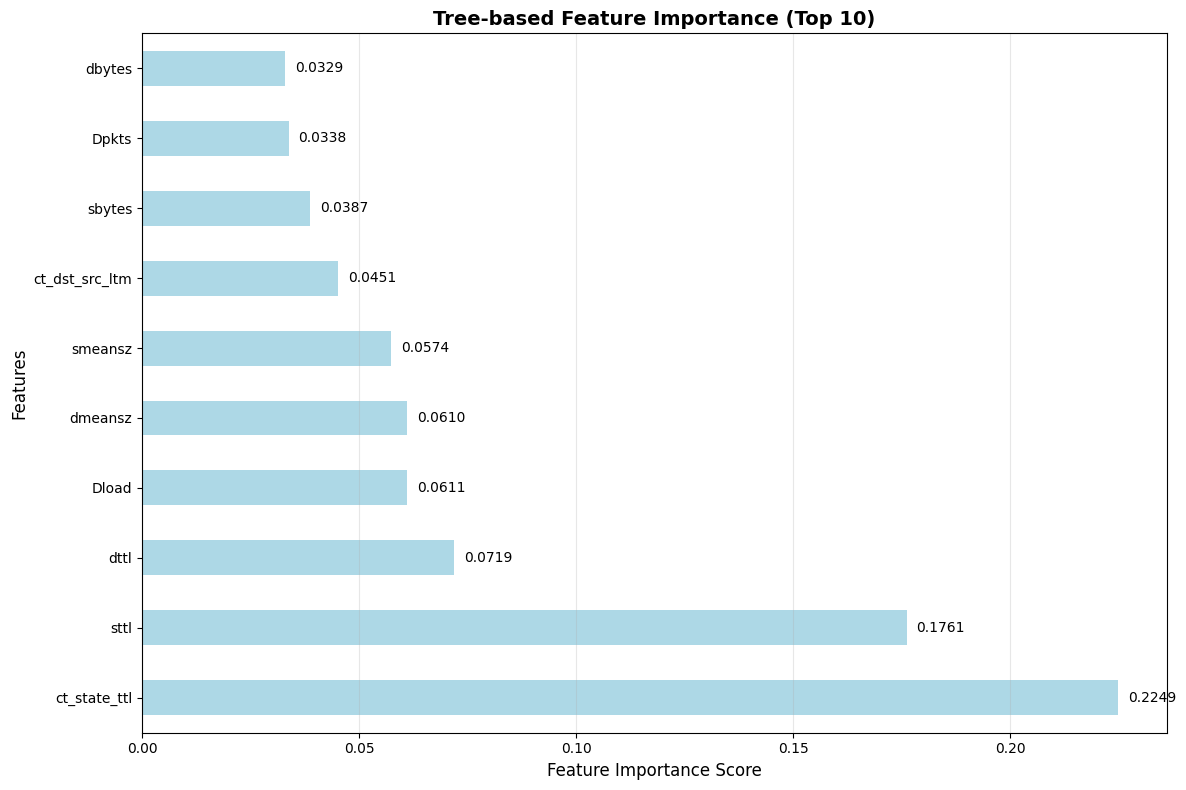

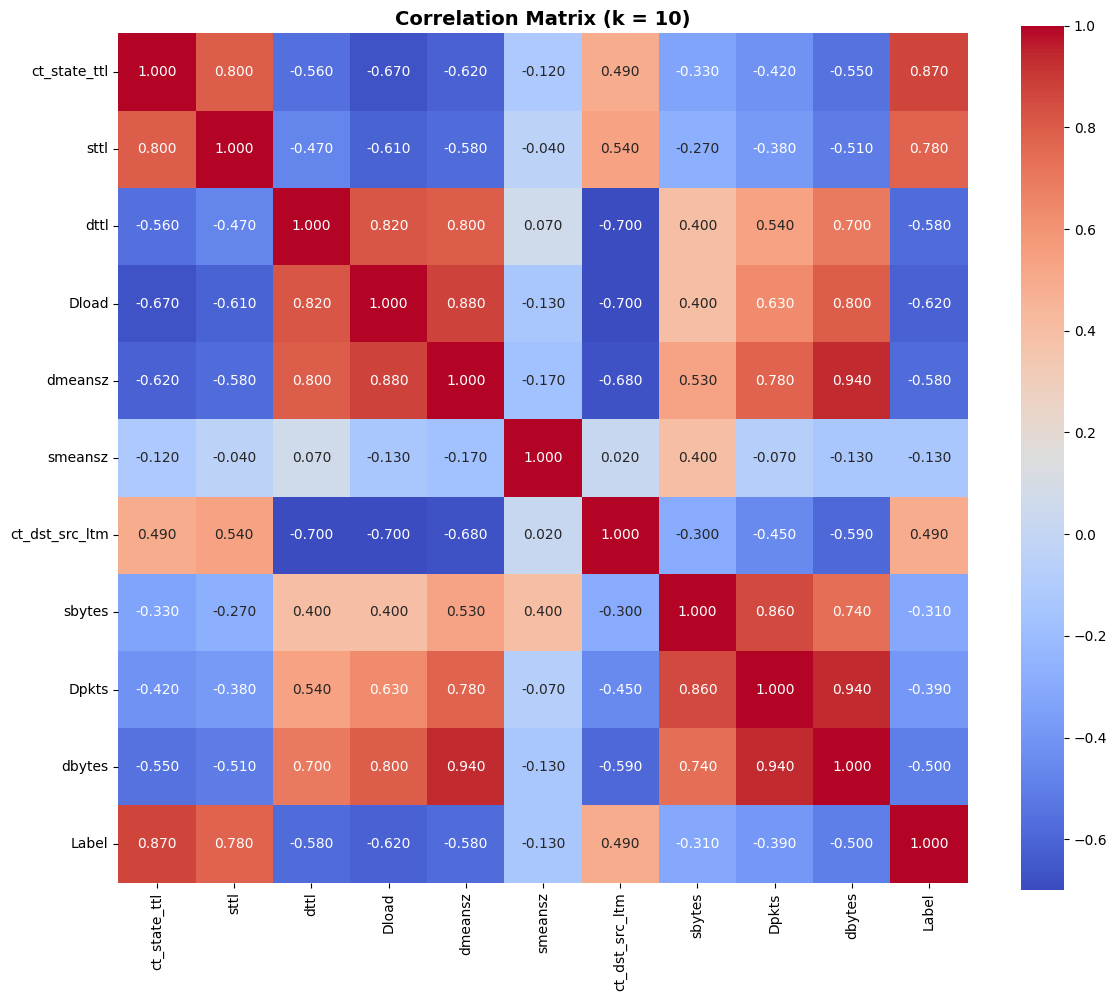


=== 타겟 상관관계 분석 (임계점: 0.3) ===
ct_state_ttl: 0.870
sttl: 0.780
dttl: 0.580
Dload: 0.620
dmeansz: 0.580
ct_dst_src_ltm: 0.490
sbytes: 0.310
Dpkts: 0.390
dbytes: 0.500

=== 피쳐 간 상관관계 분석 (임계점: 0.8) ===
dttl - Dload: 0.820
  → Dload 제거 (중요도: 0.0611)
dmeansz - dbytes: 0.940
  → dbytes 제거 (중요도: 0.0329)
sbytes - Dpkts: 0.860
  → Dpkts 제거 (중요도: 0.0338)

총 제거된 피쳐: ['Dload', 'dbytes', 'Dpkts']

=== 최종 선택된 피쳐 (6개) ===
ct_state_ttl: 0.2249
sttl: 0.1761
dttl: 0.0719
dmeansz: 0.0610
ct_dst_src_ltm: 0.0451
sbytes: 0.0387

=== 피쳐 선택 요약 ===
원본 피쳐 수: 41
최종 선택된 피쳐 수: 6
선택 기준:
  - Tree-based 상위 K개: 10
  - 타겟 상관관계 최소: 0.3
  - 피쳐 간 상관관계 임계점: 0.8

선택된 피쳐:
  - ct_state_ttl: 0.2249
  - sttl: 0.1761
  - dttl: 0.0719
  - dmeansz: 0.0610
  - ct_dst_src_ltm: 0.0451
  - sbytes: 0.0387



In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import Lasso
from sklearn.decomposition import PCA
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

class CustomFeatureEngineer:
    def __init__(self, top_k=10, corr_threshold=0.8, target_corr_min=0.3, show_plots=False):
        self.original_features = None
        self.selected_features = None
        self.tree_based_importances = None
        self.top_k = top_k
        self.corr_threshold = corr_threshold
        self.target_corr_min = target_corr_min
        self.show_plots = show_plots
        self.et_model = None

    def _create_features(self, X):
        """새로운 피쳐 생성"""
        X_new = X.copy()

        # 기본 피쳐 생성
        if 'Sload' in X.columns and 'Dload' in X.columns:
            X_new['load_ratio'] = X_new['Sload'] / (X_new['Dload'] + 1e-6)

        return X_new

    def _plot_feature_importance(self, importance_series, title="Tree-based Feature Importance"):
        """Tree-based 피쳐 중요도 시각화"""
        plt.figure(figsize=(12, 8))

        # 수평 막대 그래프
        importance_series.plot(kind='barh', color='lightblue')
        plt.title(title, fontsize=14, fontweight='bold')
        plt.xlabel('Feature Importance Score', fontsize=12)
        plt.ylabel('Features', fontsize=12)
        plt.grid(axis='x', alpha=0.3)

        # 각 막대에 수치 표시
        for i, v in enumerate(importance_series.values):
            plt.text(v + max(importance_series.values) * 0.01, i, f'{v:.4f}',
                    va='center', fontsize=10)

        plt.tight_layout()
        plt.show()

    def fit(self, X, y):
        """피쳐 엔지니어링 파이프라인 학습"""
        print("=== 피쳐 선택 시작 ===")

        # 원본 피쳐 저장
        self.original_features = X.columns.tolist()

        # 피쳐 생성
        X_engineered = self._create_features(X)
        print(f"피쳐 생성 후: {X_engineered.shape[1]}개")

        # 1단계: Tree-based 피쳐 중요도 계산
        self.et_model = ExtraTreesClassifier(n_estimators=100, random_state=42)
        self.et_model.fit(X_engineered, y)

        self.tree_based_importances = pd.Series(
            self.et_model.feature_importances_,
            index=X_engineered.columns
        ).sort_values(ascending=False)

        print(f"\n=== Tree-based 피쳐 중요도 (상위 {self.top_k}개) ===")
        top_features = self.tree_based_importances.head(self.top_k)
        print(top_features)

        # Tree-based 중요도 시각화 (조건부)
        if self.show_plots:
            self._plot_feature_importance(
                top_features,
                f"Tree-based Feature Importance (Top {self.top_k})"
            )

        # 2단계: 타겟과의 상관관계 필터링 및 피쳐 간 상관관계 처리
        self.selected_features = self._simple_correlation_filtering(
            X_engineered, y, top_features.index.tolist()
        )

        print(f"\n=== 최종 선택된 피쳐 ({len(self.selected_features)}개) ===")
        for feat in self.selected_features:
            print(f"{feat}: {self.tree_based_importances[feat]:.4f}")

        return self

    def _simple_correlation_filtering(self, X, y, top_features):
        """상관관계 기반 필터링"""
        # 상관관계 매트릭스 계산
        df_corr = X[top_features].copy()
        df_corr['Label'] = y
        corr_matrix = df_corr.corr().round(2)

        # 히트맵 시각화 (조건부)
        if self.show_plots:
            plt.figure(figsize=(12, 10))
            sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".3f",
                       square=True, cbar=True)
            plt.title(f'Correlation Matrix (k = {self.top_k})', fontsize=14, fontweight='bold')
            plt.tight_layout()
            plt.show()

        # 타겟과의 상관관계 확인
        target_correlations = corr_matrix['Label'].drop('Label').abs()

        # 타겟 상관관계 임계점 이상인 피쳐들만 유지
        qualified_features = target_correlations[
            target_correlations >= self.target_corr_min
        ].index.tolist()

        print(f"\n=== 타겟 상관관계 분석 (임계점: {self.target_corr_min}) ===")
        for feat in qualified_features:
            print(f"{feat}: {target_correlations[feat]:.3f}")

        # 피쳐 간 높은 상관관계 처리
        feature_corr_matrix = corr_matrix.drop('Label', axis=0).drop('Label', axis=1)
        selected_features = self._remove_high_correlation_features(
            qualified_features, feature_corr_matrix
        )

        return selected_features

    def _remove_high_correlation_features(self, features, corr_matrix):
        """높은 상관관계를 가진 피쳐 중 하나만 선택"""
        features_to_remove = set()
        processed_pairs = set()

        print(f"\n=== 피쳐 간 상관관계 분석 (임계점: {self.corr_threshold}) ===")

        for i, feat1 in enumerate(features):
            for j, feat2 in enumerate(features):
                if i < j and feat1 not in features_to_remove and feat2 not in features_to_remove:
                    pair = tuple(sorted([feat1, feat2]))
                    if pair not in processed_pairs:
                        corr_val = abs(corr_matrix.loc[feat1, feat2])

                        if corr_val > self.corr_threshold:
                            print(f"{feat1} - {feat2}: {corr_val:.3f}")

                            # Tree 중요도가 낮은 피쳐 제거
                            if self.tree_based_importances[feat1] < self.tree_based_importances[feat2]:
                                features_to_remove.add(feat1)
                                print(f"  → {feat1} 제거 (중요도: {self.tree_based_importances[feat1]:.4f})")
                            else:
                                features_to_remove.add(feat2)
                                print(f"  → {feat2} 제거 (중요도: {self.tree_based_importances[feat2]:.4f})")

                        processed_pairs.add(pair)

        # 최종 선택된 피쳐들
        selected_features = [f for f in features if f not in features_to_remove]

        if features_to_remove:
            print(f"\n총 제거된 피쳐: {list(features_to_remove)}")
        else:
            print(f"\n높은 상관관계를 가진 피쳐 쌍이 없음")

        return selected_features

    def transform(self, X):
        """학습된 파이프라인을 사용하여 데이터 변환"""
        if self.selected_features is None:
            raise ValueError("모델을 먼저 학습시켜야 합니다. fit() 메서드를 호출하세요.")

        # 피쳐 생성
        X_engineered = self._create_features(X)

        # 선택된 피쳐만 반환
        return X_engineered[self.selected_features]

    def fit_transform(self, X, y):
        """학습과 변환을 동시에 수행"""
        return self.fit(X, y).transform(X)

    def get_feature_names(self):
        """선택된 피쳐 이름 반환"""
        return self.selected_features

    def get_feature_importances(self):
        """선택된 피쳐의 중요도 반환"""
        if self.selected_features is None or self.tree_based_importances is None:
            return None
        return self.tree_based_importances[self.selected_features]

    def get_summary(self):
        """피쳐 선택 결과 요약"""
        if self.selected_features is None:
            return "모델이 아직 학습되지 않았습니다."

        summary = f"""
=== 피쳐 선택 요약 ===
원본 피쳐 수: {len(self.original_features) if self.original_features else 'N/A'}
최종 선택된 피쳐 수: {len(self.selected_features)}
선택 기준:
  - Tree-based 상위 K개: {self.top_k}
  - 타겟 상관관계 최소: {self.target_corr_min}
  - 피쳐 간 상관관계 임계점: {self.corr_threshold}

선택된 피쳐:
"""
        for feat in self.selected_features:
            importance = self.tree_based_importances[feat]
            summary += f"  - {feat}: {importance:.4f}\n"

        return summary

if __name__ == '__main__':
    df_train, df_test = pd.read_csv("DS_term/3_Preprocessing_DataSet.csv", low_memory=False), pd.read_csv("DS_term/3_Preprocessing_TestDataSet.csv", low_memory=False)
    X_train, X_test = df_train.drop(["Label"], axis=1), df_test.drop(["Label"], axis=1)
    y_train, y_test = df_train["Label"], df_test["Label"]

    fe = CustomFeatureEngineer(
        top_k=10,
        corr_threshold=0.8,
        target_corr_min=0.3,
        show_plots=True
    )

    # 학습 및 변환
    X_transformed = fe.fit_transform(X_train, y_train)
    X_transformed["Label"] = y_train

    # 테스트 데이터 변환
    X_test_transformed = fe.transform(X_test)
    X_transformed["Label"] = y_test

    # 결과 확인
    print(fe.get_summary())
    selected_features = fe.get_feature_names()

    # 결과 저장
    X_transformed.to_csv("DS_term/4_Feature_engineering_DataSet.csv")
    X_test_transformed.to_csv("DS_term/4_Feature_engineering_TestDataSet.csv")


데이터 불러오기
데이터 로드 완료: 771931행 x 48열

사용 모델: Logistic Regression
데이터 샘플 수: 617545
K-Fold Cross Validation 시작 (k=3)

==================== Fold 1 ====================

--- Fold 1 데이터 분포 ---
훈련 세트 - 일반: 278669, 공격: 22804
테스트 세트 - 일반: 142458, 공격: 18761

--- Fold 1: Logistic Regression 모델 성능 평가 ---
정확도 (Accuracy): 0.9854
정밀도 (Precision): 0.9855
재현율 (Recall): 0.9854
F1-점수 (F1-Score): 0.9854
ROC AUC: 0.9947

혼동 행렬 (Confusion Matrix):
[[141207   1251]
 [  1101  17660]]

==================== Fold 2 ====================

--- Fold 2 데이터 분포 ---
훈련 세트 - 일반: 278783, 공격: 22766
테스트 세트 - 일반: 142314, 공격: 18825

--- Fold 2: Logistic Regression 모델 성능 평가 ---
정확도 (Accuracy): 0.9856
정밀도 (Precision): 0.9856
재현율 (Recall): 0.9856
F1-점수 (F1-Score): 0.9856
ROC AUC: 0.9945

혼동 행렬 (Confusion Matrix):
[[141123   1191]
 [  1128  17697]]

==================== Fold 3 ====================

--- Fold 3 데이터 분포 ---
훈련 세트 - 일반: 278665, 공격: 22806
테스트 세트 - 일반: 142447, 공격: 18698

--- Fold 3: Logistic Regression 모델 성능 평가 ---
정확도 (

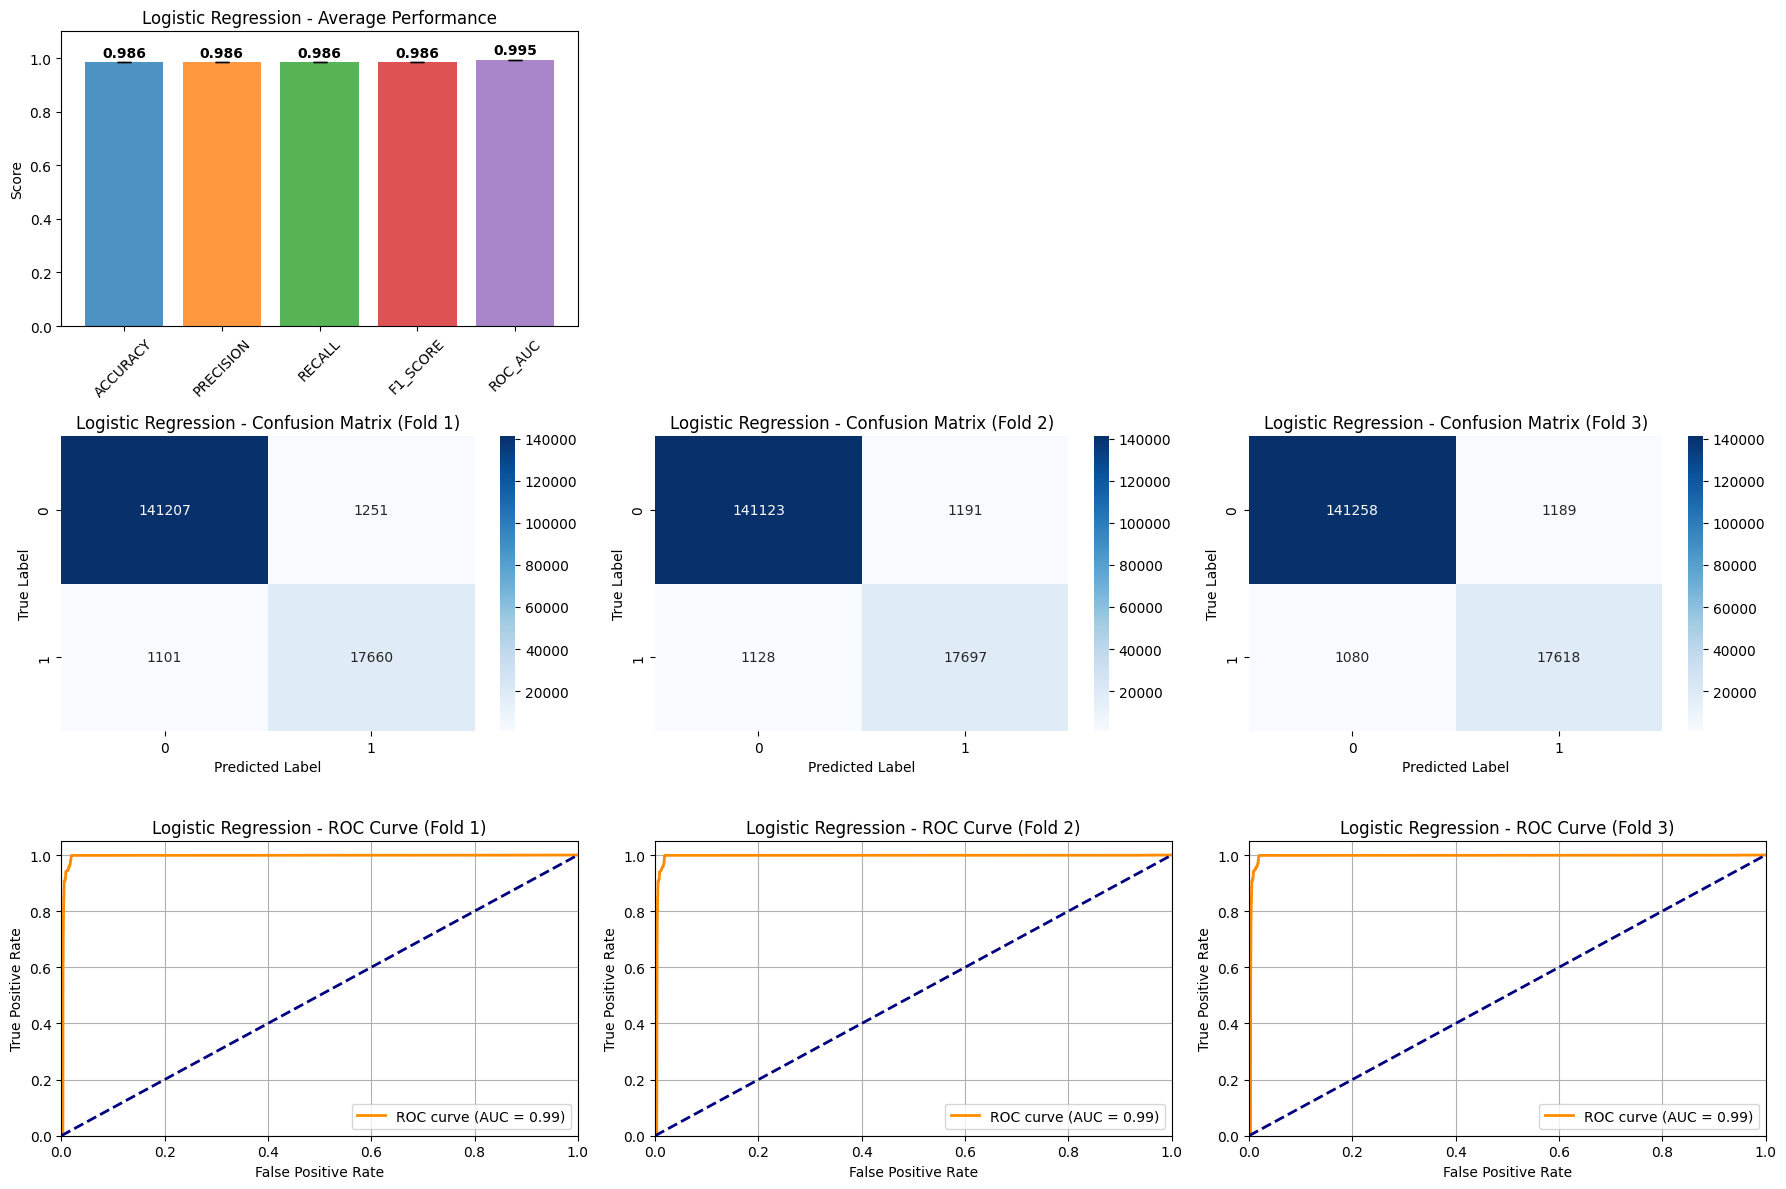


사용 모델: Decision Tree
데이터 샘플 수: 617545
K-Fold Cross Validation 시작 (k=3)

==================== Fold 1 ====================

--- Fold 1 데이터 분포 ---
훈련 세트 - 일반: 278669, 공격: 22804
테스트 세트 - 일반: 142458, 공격: 18761

--- Fold 1: Decision Tree 모델 성능 평가 ---
정확도 (Accuracy): 0.9990
정밀도 (Precision): 0.9990
재현율 (Recall): 0.9990
F1-점수 (F1-Score): 0.9990
ROC AUC: 0.9980

혼동 행렬 (Confusion Matrix):
[[142368     90]
 [    76  18685]]

==================== Fold 2 ====================

--- Fold 2 데이터 분포 ---
훈련 세트 - 일반: 278783, 공격: 22766
테스트 세트 - 일반: 142314, 공격: 18825

--- Fold 2: Decision Tree 모델 성능 평가 ---
정확도 (Accuracy): 0.9988
정밀도 (Precision): 0.9988
재현율 (Recall): 0.9988
F1-점수 (F1-Score): 0.9988
ROC AUC: 0.9976

혼동 행렬 (Confusion Matrix):
[[142214    100]
 [    93  18732]]

==================== Fold 3 ====================

--- Fold 3 데이터 분포 ---
훈련 세트 - 일반: 278665, 공격: 22806
테스트 세트 - 일반: 142447, 공격: 18698

--- Fold 3: Decision Tree 모델 성능 평가 ---
정확도 (Accuracy): 0.9990
정밀도 (Precision): 0.9990
재현율 (Recall): 0.9

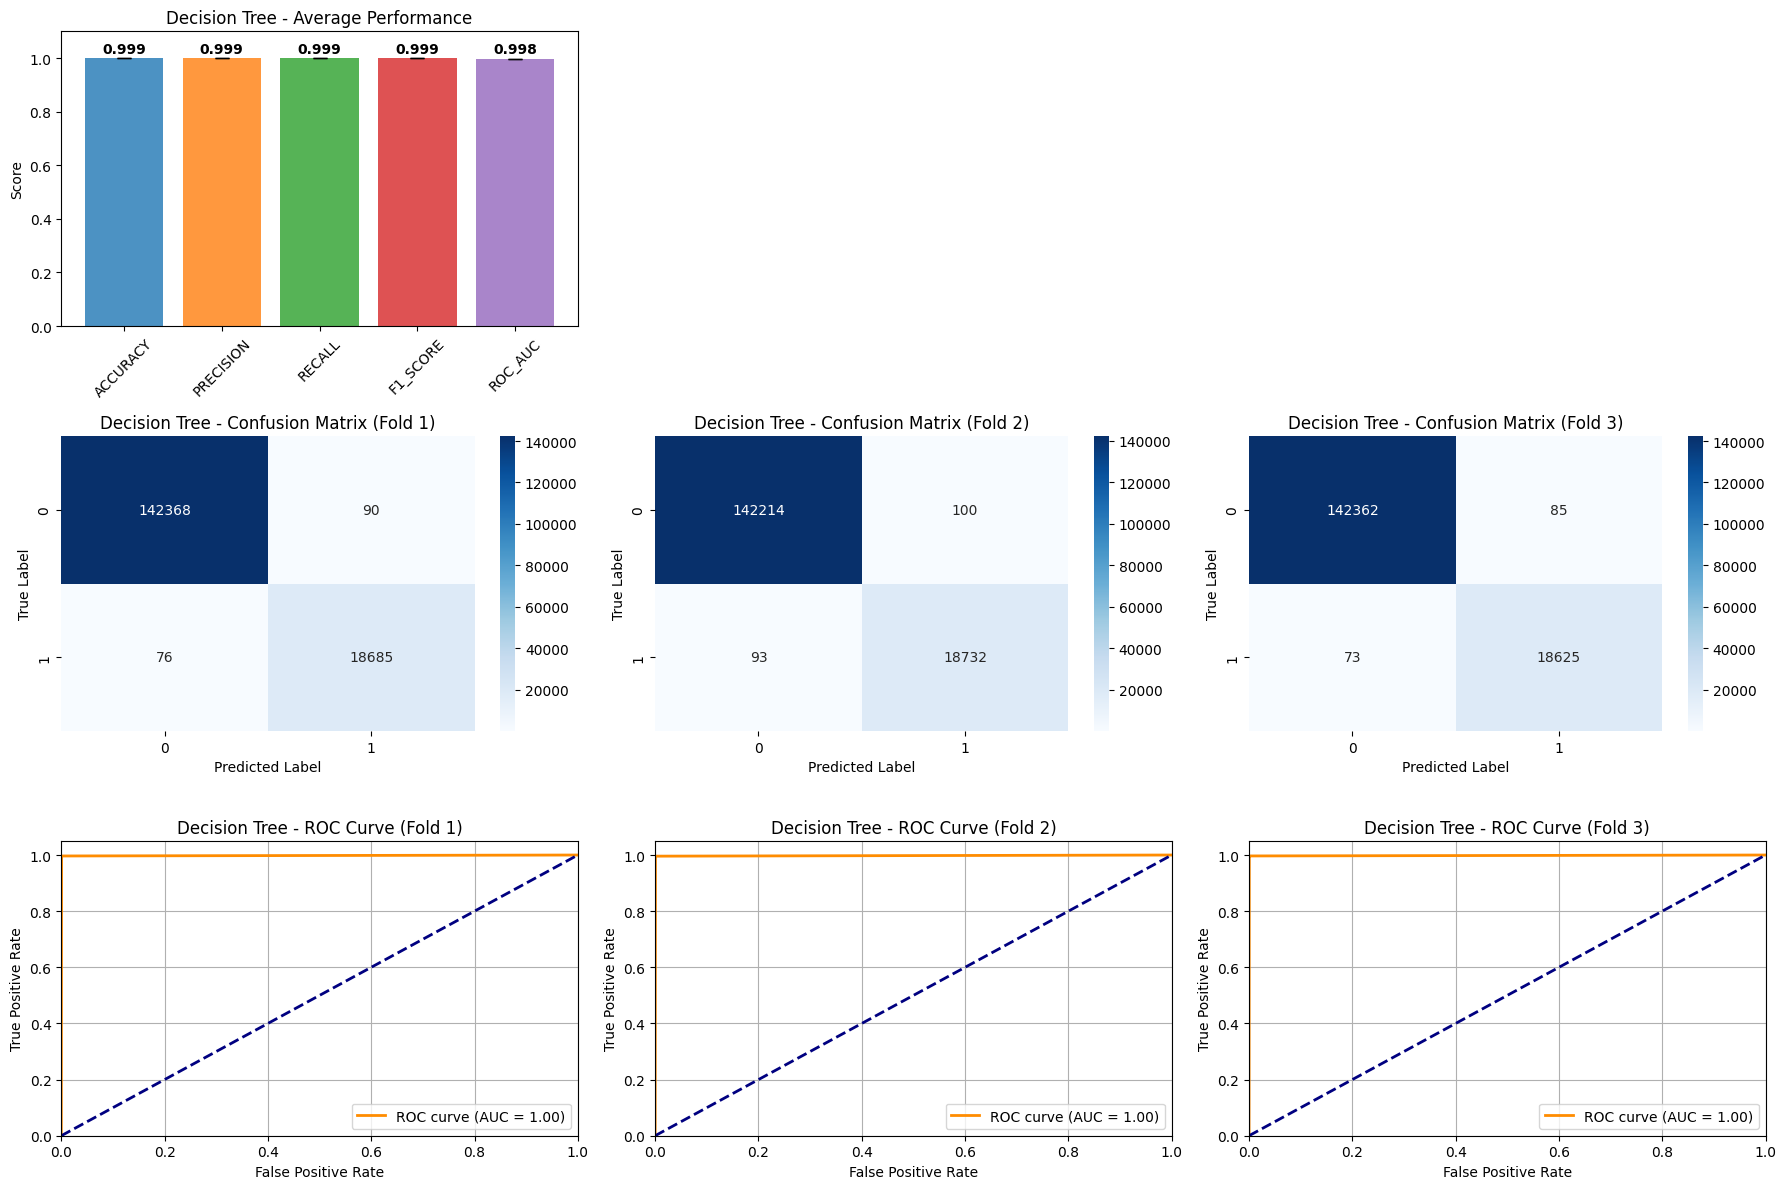


사용 모델: Random Forest
데이터 샘플 수: 617545
K-Fold Cross Validation 시작 (k=3)

==================== Fold 1 ====================

--- Fold 1 데이터 분포 ---
훈련 세트 - 일반: 278669, 공격: 22804
테스트 세트 - 일반: 142458, 공격: 18761

--- Fold 1: Random Forest 모델 성능 평가 ---
정확도 (Accuracy): 0.9990
정밀도 (Precision): 0.9990
재현율 (Recall): 0.9990
F1-점수 (F1-Score): 0.9990
ROC AUC: 0.9997

혼동 행렬 (Confusion Matrix):
[[142368     90]
 [    72  18689]]

==================== Fold 2 ====================

--- Fold 2 데이터 분포 ---
훈련 세트 - 일반: 278783, 공격: 22766
테스트 세트 - 일반: 142314, 공격: 18825

--- Fold 2: Random Forest 모델 성능 평가 ---
정확도 (Accuracy): 0.9990
정밀도 (Precision): 0.9990
재현율 (Recall): 0.9990
F1-점수 (F1-Score): 0.9990
ROC AUC: 0.9997

혼동 행렬 (Confusion Matrix):
[[142239     75]
 [    92  18733]]

==================== Fold 3 ====================

--- Fold 3 데이터 분포 ---
훈련 세트 - 일반: 278665, 공격: 22806
테스트 세트 - 일반: 142447, 공격: 18698

--- Fold 3: Random Forest 모델 성능 평가 ---
정확도 (Accuracy): 0.9991
정밀도 (Precision): 0.9991
재현율 (Recall): 0.9

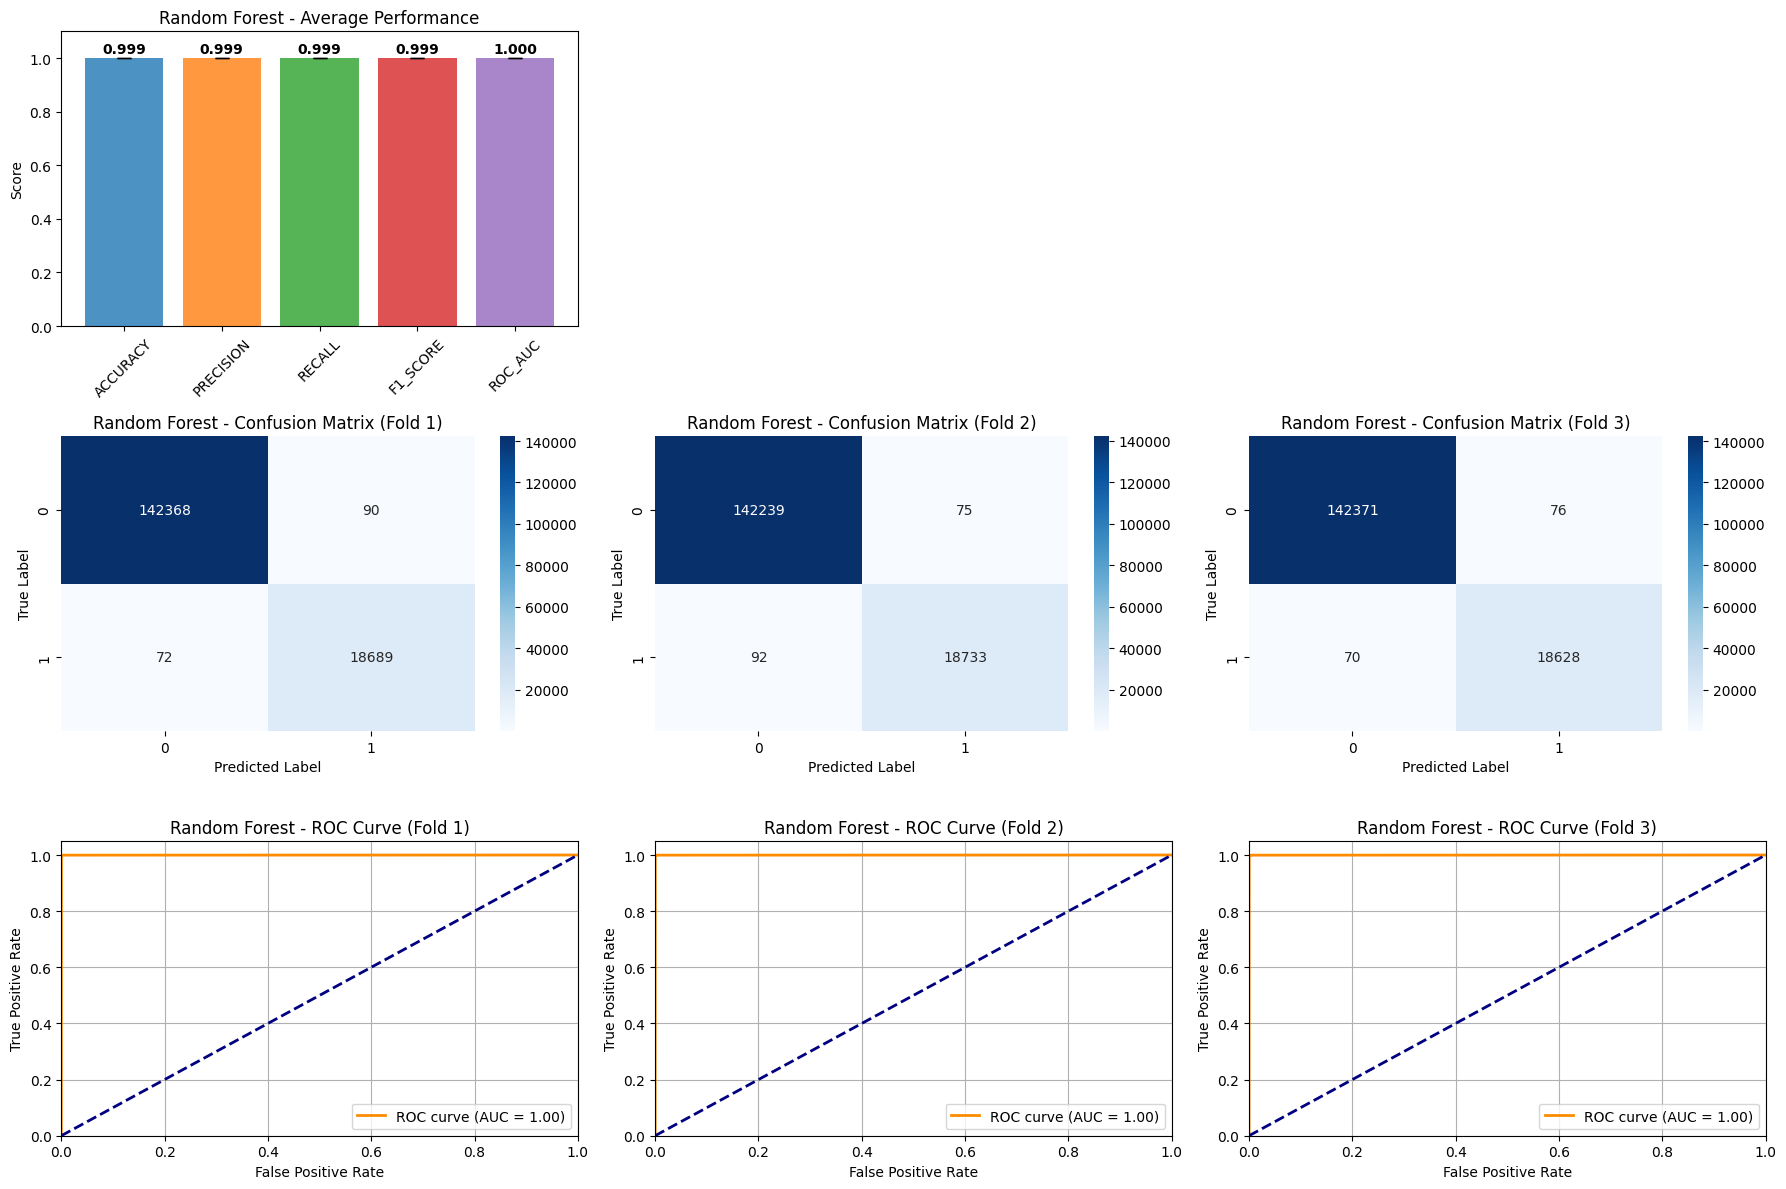


사용 모델: Linear Regression
데이터 샘플 수: 617545
K-Fold Cross Validation 시작 (k=3)

==================== Fold 1 ====================

--- Fold 1 데이터 분포 ---
훈련 세트 - 일반: 278669, 공격: 22804
테스트 세트 - 일반: 142458, 공격: 18761

임계값: -0.08938372251900645
가중치된 지표: Accuracy(0.1164) + Precision(0.1164) + Recall(1.0000) + F1(0.2085)

임계값: -0.007078713713268556
가중치된 지표: Accuracy(0.4386) + Precision(0.1715) + Recall(0.9987) + F1(0.2928)

임계값: 0.07522629509246934
가중치된 지표: Accuracy(0.9262) + Precision(0.6120) + Recall(0.9987) + F1(0.7589)

임계값: 0.15753130389820724
가중치된 지표: Accuracy(0.9824) + Precision(0.8692) + Recall(0.9987) + F1(0.9295)

임계값: 0.23983631270394512
가중치된 지표: Accuracy(0.9824) + Precision(0.8692) + Recall(0.9987) + F1(0.9295)

임계값: 0.322141321509683
가중치된 지표: Accuracy(0.9824) + Precision(0.8692) + Recall(0.9987) + F1(0.9295)

임계값: 0.40444633031542093
가중치된 지표: Accuracy(0.9830) + Precision(0.8938) + Recall(0.9695) + F1(0.9301)

임계값: 0.4867513391211588
가중치된 지표: Accuracy(0.9854) + Precision(0.9339) + Re

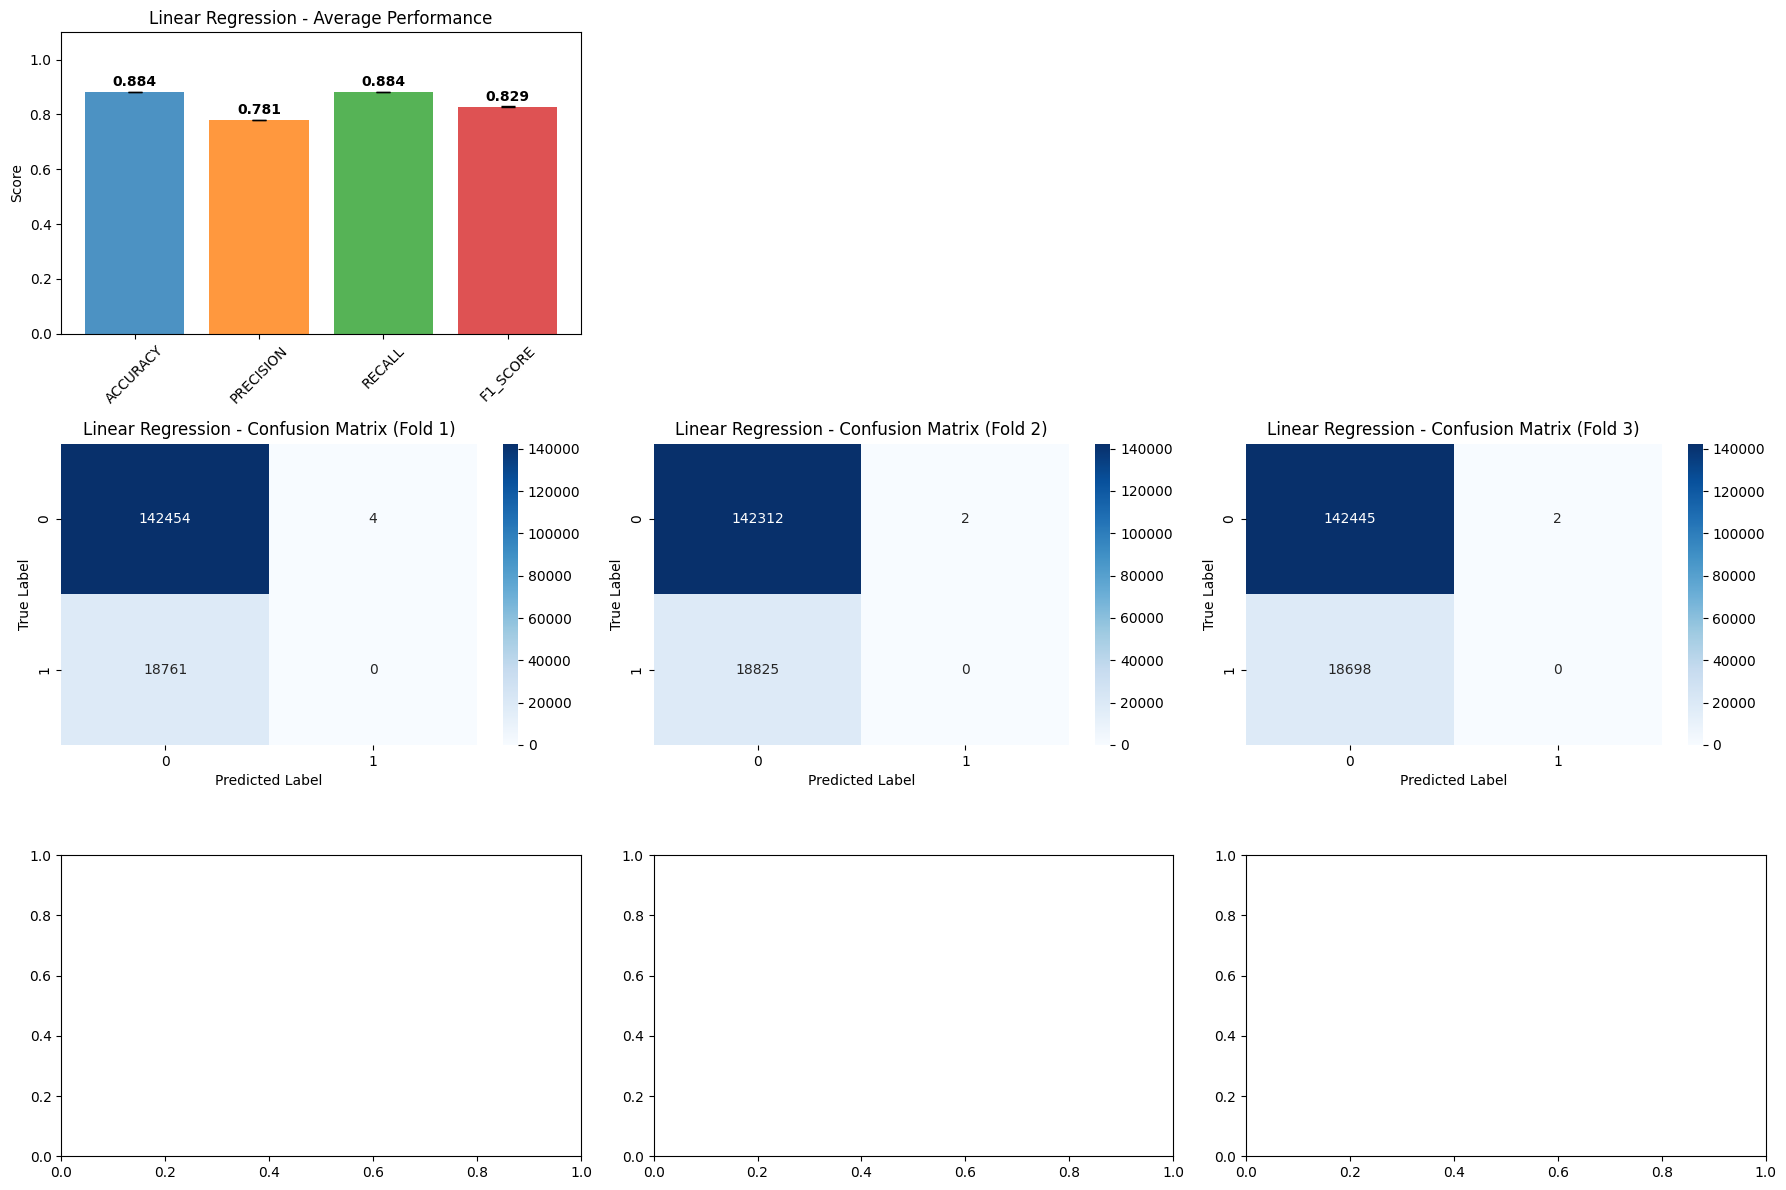


사용 모델: PCA Regression
데이터 샘플 수: 617545
K-Fold Cross Validation 시작 (k=3)

==================== Fold 1 ====================

--- Fold 1 데이터 분포 ---
훈련 세트 - 일반: 278669, 공격: 22804
테스트 세트 - 일반: 142458, 공격: 18761

임계값: -4.710697850194288
가중치된 지표: Accuracy(0.0756) + Precision(0.0756) + Recall(1.0000) + F1(0.1406)

임계값: -4.300283490322675
가중치된 지표: Accuracy(0.0551) + Precision(0.0533) + Recall(0.6853) + F1(0.0989)

임계값: -3.889869130451062
가중치된 지표: Accuracy(0.0570) + Precision(0.0263) + Recall(0.3184) + F1(0.0486)

임계값: -3.4794547705794487
가중치된 지표: Accuracy(0.0610) + Precision(0.0195) + Recall(0.2319) + F1(0.0360)

임계값: -3.069040410707836
가중치된 지표: Accuracy(0.0584) + Precision(0.0121) + Recall(0.1422) + F1(0.0223)

임계값: -2.6586260508362227
가중치된 지표: Accuracy(0.0603) + Precision(0.0086) + Recall(0.1003) + F1(0.0159)

임계값: -2.2482116909646095
가중치된 지표: Accuracy(0.0633) + Precision(0.0084) + Recall(0.0976) + F1(0.0155)

임계값: -1.8377973310929967
가중치된 지표: Accuracy(0.0633) + Precision(0.0084) + Recall(0.

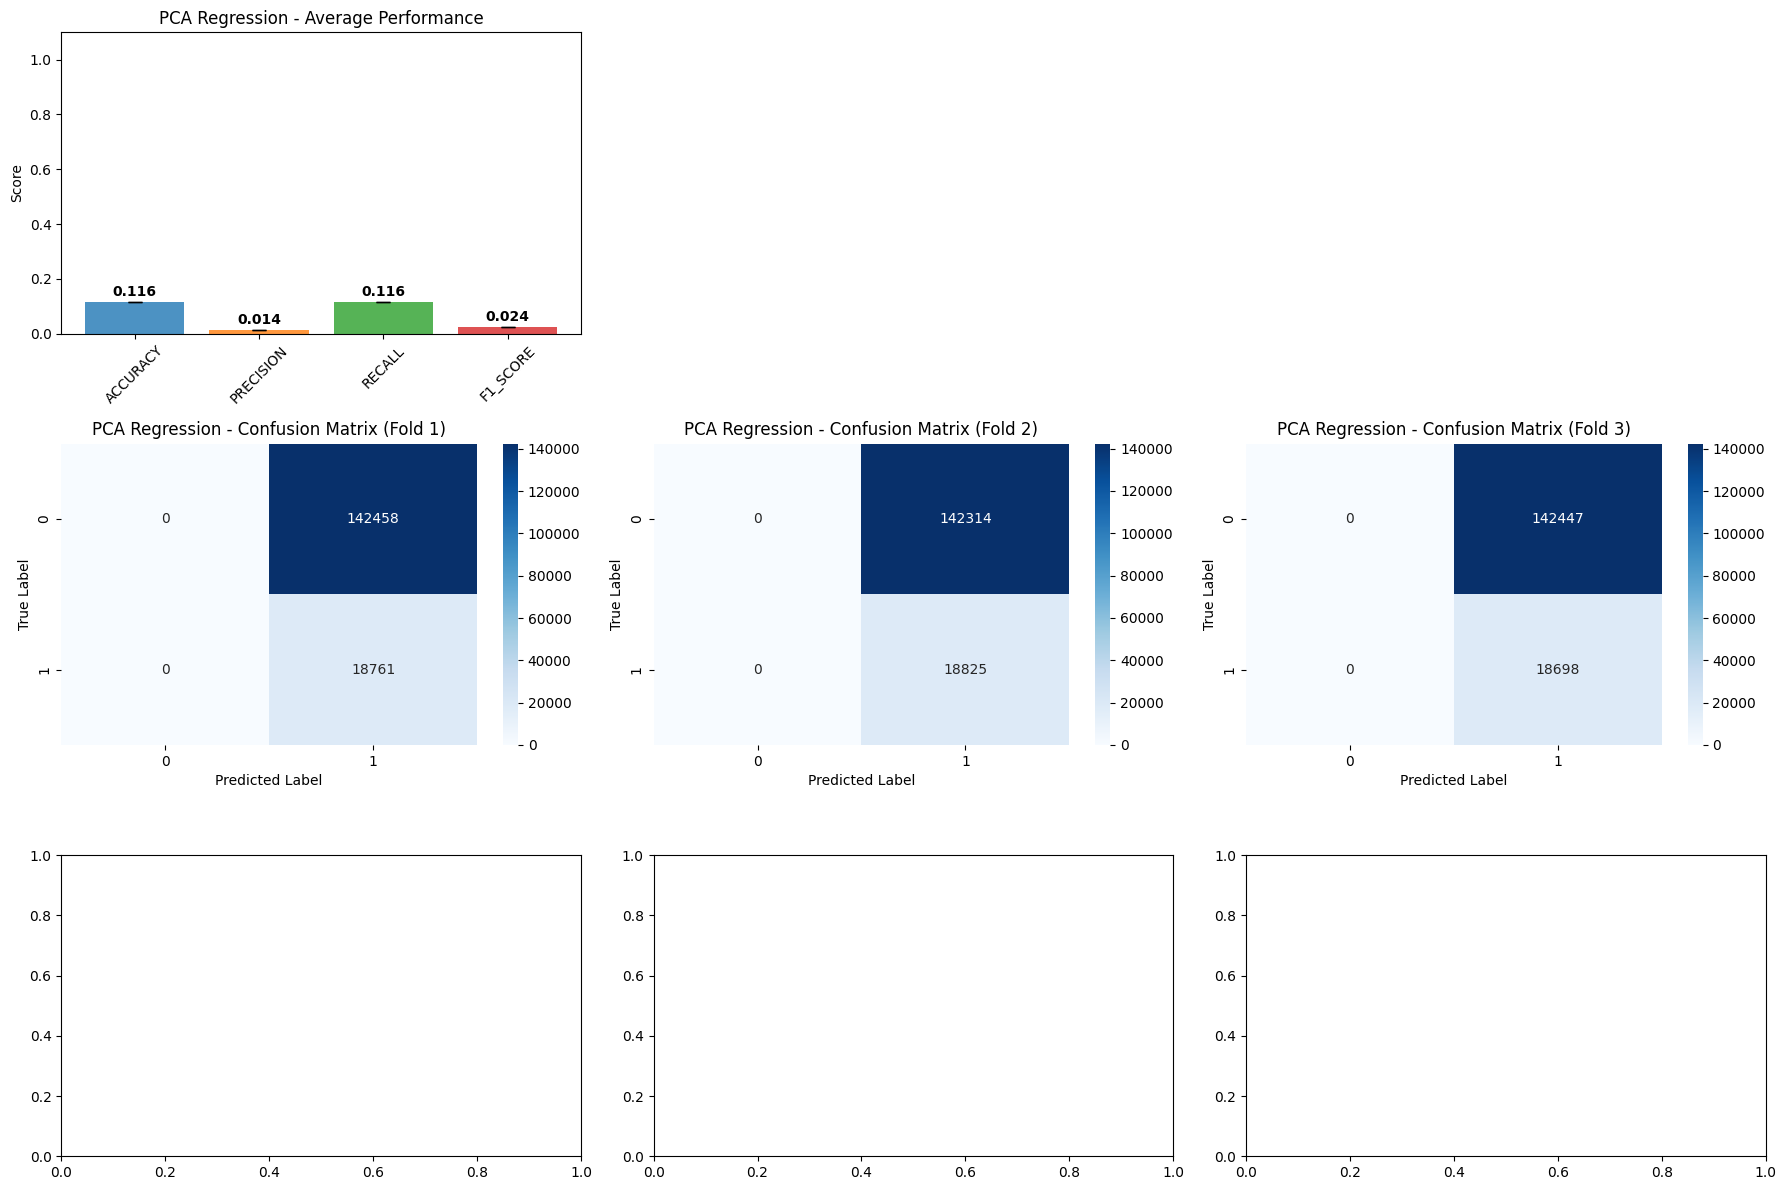


모든 모델링 절차가 완료되었습니다!


In [26]:
import pandas as pd
import numpy as np
from pathlib import Path
import sys
import os

# 머신러닝 라이브러리
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    StratifiedKFold,
    KFold,
)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    auc,
    precision_score,
    recall_score,
    f1_score,
)
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

# 시각화 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

# 경고 메시지 숨기기
import warnings

warnings.filterwarnings("ignore")


class ModelingPipeline:
    """
    모델링 파이프라인 클래스
    """

    def __init__(self, test_size=0.3):
        self.data_path="DS_term/1_Raw_DataSet.csv"
        self.df = None
        self.test_size = test_size
        self.results = {}

    def load_data(self):
        """원본 데이터를 불러오기"""
        print("\n" + "=" * 50)
        print("데이터 불러오기")
        print("=" * 50)

        try:
            self.data_path = "DS_term/1_Raw_DataSet.csv"
            self.df = pd.read_csv(self.data_path, low_memory=False)
            print(f"데이터 로드 완료: {self.df.shape[0]}행 x {self.df.shape[1]}열")
            return True
        except FileNotFoundError:
            print(f"파일을 찾을 수 없습니다: {self.data_path}")
            return False
        except Exception as e:
            print(f"데이터 로드 중 오류 발생: {e}")
            return False

    def preprocess(self, df_train=None, df_test=None):
        """데이터 전처리"""
        with open(os.devnull, "w") as fnull:
            original_stdout = sys.stdout
            sys.stdout = fnull
            try:

                # 데이터 클리닝
                df_train_clean, df_test_clean = data_cleaning(df_train, df_test, is_plot=False)

                # 데이터 전처리
                prep = CustomPreprocessor()
                prep_train = prep.fit_transform(df_train_clean)
                prep_test = prep.transform(df_test_clean)

                del df_train_clean, df_test_clean # 클리닝 데이터 캐시 제거

                X_train, X_test = prep_train.drop(["Label"], axis=1), prep_test.drop(["Label"], axis=1)
                y_train, y_test = prep_train["Label"], prep_test["Label"]

                del prep_train, prep_test # 전처리 데이터 캐시 제거

                # 특징 선택
                fe = CustomFeatureEngineer(
                    top_k=10,
                    corr_threshold=0.8,
                    target_corr_min=0.3,
                    show_plots=False
                )

                # 학습 및 변환
                X_transformed = fe.fit_transform(X_train, y_train)
                X_transformed["Label"] = y_train

                # 테스트 데이터 변환
                X_test_transformed = fe.transform(X_test)
                X_test_transformed["Label"] = y_test

                return X_transformed, X_test_transformed

            finally:
                sys.stdout = original_stdout

    # ========== 예측 함수 ==========
    def linear_regression_predict(self, X_train, X_test, y_train, y_test):
        """
        선형 회귀를 사용한 분류 예측
        Args:
            X_train, X_test: 훈련/테스트 특성 데이터
            y_train, y_test: 훈련/테스트 타겟 데이터
        Returns:
            tuple: (예측값, 모델 객체, 최적 임계값)
        """
        # 모델 생성 및 훈련
        model = LinearRegression()
        model.fit(X_train, y_train)

        # 예측
        y_pred_continuous = model.predict(X_test)

        # 예측값 범위 확인
        pred_min, pred_max = y_pred_continuous.min(), y_pred_continuous.max()

        # 다양한 임계값에서 성능 평가
        best_metric = 0
        best_threshold = 0.5
        best_predictions = None

        # 예측값 범위 내에서 임계값 후보 생성
        threshold_candidates = np.linspace(pred_min, pred_max, 20)

        for thresh in threshold_candidates:
            # 현재 임계값으로 분류
            y_pred_temp = np.where(y_pred_continuous >= thresh, 1, 0)

            # 지표 계산
            accuracy = accuracy_score(y_test, y_pred_temp)
            precision = precision_score(y_test, y_pred_temp, zero_division=0)
            recall = recall_score(y_test, y_pred_temp, zero_division=0)
            f1 = f1_score(y_test, y_pred_temp, zero_division=0)

            # 최고 성능 임계값 업데이트
            if accuracy*0.2 + precision*0.2 + recall*0.4 + f1*0.2 > best_metric:
                best_accuracy = accuracy
                best_threshold = thresh
                best_predictions = y_pred_temp

            print(f"\n임계값: {thresh}\n가중치된 지표: Accuracy({accuracy:.4f}) + Precision({precision:.4f}) + Recall({recall:.4f}) + F1({f1:.4f})")

        return best_predictions, model, best_threshold

    def logistic_regression_predict(self, X_train, X_test, y_train, y_test):
        """
        로지스틱 회귀 예측

        Returns:
            tuple: (예측값, 확률값, 모델 객체)
        """
        model = LogisticRegression()
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

        return y_pred, y_pred_proba, model

    def random_forest_predict(self, X_train, X_test, y_train, y_test):
        """
        랜덤 포레스트 예측

        Returns:
            tuple: (예측값, 확률값, 모델 객체)
        """
        model = RandomForestClassifier(random_state=42, n_jobs=-1)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

        return y_pred, y_pred_proba, model

    def decision_tree_predict(self, X_train, X_test, y_train, y_test):
        """
        의사결정트리 예측

        Returns:
            tuple: (예측값, 확률값, 모델 객체)
        """
        model = DecisionTreeClassifier(random_state=42)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

        return y_pred, y_pred_proba, model

    def PCA_regression_predict(self, X_train, X_test, y_train, y_test, n_components=1):
        """
        PCA 기반 차원축소 후 분류 예측

        Args:
            X_train, X_test: 훈련/테스트 특성 데이터
            y_train, y_test: 훈련/테스트 타겟 데이터
            n_components: PCA 주성분 개수

        Returns:
            tuple: (예측값, PCA 객체, 최적 임계값, 성능 지표)
        """

        # 1단계: 훈련 데이터로 PCA 학습
        pca = PCA(n_components=n_components)
        X_train_pca = pca.fit_transform(X_train)  # 훈련 데이터로 학습 및 변환

        # 2단계: 훈련 데이터에서 최적 임계값 찾기
        if n_components == 1:
            train_pca_values = X_train_pca.flatten()
        else:
            train_pca_values = X_train_pca[:, 0]

        # 훈련 데이터 범위에서 임계값 후보 생성
        pca_min, pca_max = train_pca_values.min(), train_pca_values.max()
        threshold_candidates = np.linspace(pca_min, pca_max, 20)

        best_composite_score = 0
        best_threshold = 0.5

        for thresh in threshold_candidates:
            # 훈련 데이터로 분류 성능 평가
            y_pred_train = np.where(train_pca_values >= thresh, 1, 0)

            # 훈련 데이터 기준 성능 지표 계산
            accuracy = accuracy_score(y_train, y_pred_train)
            precision = precision_score(y_train, y_pred_train, zero_division=0)
            recall = recall_score(y_train, y_pred_train, zero_division=0)
            f1 = f1_score(y_train, y_pred_train, zero_division=0)

            # 가중 복합 점수 계산
            composite_score = accuracy*0.2 + precision*0.2 + recall*0.4 + f1*0.2

            if composite_score > best_composite_score:
                best_composite_score = composite_score
                best_threshold = thresh

            print(f"\n임계값: {thresh}\n가중치된 지표: Accuracy({accuracy:.4f}) + Precision({precision:.4f}) + Recall({recall:.4f}) + F1({f1:.4f})")

        # 3단계: 테스트 데이터 변환 및 예측
        X_test_pca = pca.transform(X_test)  # 학습된 PCA로 테스트 데이터 변환

        if n_components == 1:
            test_pca_values = X_test_pca.flatten()
        else:
            test_pca_values = X_test_pca[:, 0]

        # 찾은 임계값으로 테스트 데이터 예측
        y_pred = np.where(test_pca_values >= best_threshold, 1, 0)

        return y_pred, pca, best_threshold


    # ========== 지표 계산 함수 ==========
    def calculate_metrics(self, y_true, y_pred, y_pred_proba=None):
        """
        성능 지표 계산

        Args:
            y_true: 실제 라벨
            y_pred: 예측 라벨
            y_pred_proba: 예측 확률 (선택사항)

        Returns:
            dict: 성능 지표 딕셔너리
        """
        metrics = {
            "accuracy": accuracy_score(y_true, y_pred),
            "precision": precision_score(
                y_true, y_pred, average="weighted", zero_division=0
            ),
            "recall": recall_score(y_true, y_pred, average="weighted", zero_division=0),
            "f1_score": f1_score(y_true, y_pred, average="weighted", zero_division=0),
            "confusion_matrix": confusion_matrix(y_true, y_pred),
        }

        # ROC AUC는 확률값이 있을 때만 계산
        if y_pred_proba is not None:
            try:
                metrics["roc_auc"] = roc_auc_score(y_true, y_pred_proba)
            except ValueError:
                metrics["roc_auc"] = None
        else:
            metrics["roc_auc"] = None

        return metrics

    def plot_confusion_matrix(self, cm, model_name, fold_num=None):
        """
        혼동 행렬 시각화

        Args:
            cm: 혼동 행렬
            model_name: 모델 이름
            fold_num: 폴드 번호 (선택사항)

        Returns:
            matplotlib.pyplot
        """
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=True)

        title = f"{model_name} - Confusion Matrix"
        if fold_num is not None:
            title += f" (Fold {fold_num})"

        plt.title(title)
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")

        return plt

    def plot_roc_curve(self, y_true, y_pred_proba, model_name, fold_num=None):
        """
        ROC 곡선 시각화

        Args:
            y_true: 실제 라벨
            y_pred_proba: 예측 확률
            model_name: 모델 이름
            fold_num: 폴드 번호 (선택사항)

        Returns:
            matplotlib.pyplot
        """
        if y_pred_proba is None:
            print("ROC 곡선을 그리려면 예측 확률이 필요합니다.")
            return

        try:
            fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
            roc_auc = auc(fpr, tpr)

            plt.plot(
                fpr,
                tpr,
                color="darkorange",
                lw=2,
                label=f"ROC curve (AUC = {roc_auc:.2f})",
            )
            plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")

            title = f"{model_name} - ROC Curve"
            if fold_num is not None:
                title += f" (Fold {fold_num})"
            plt.title(title)

            plt.legend(loc="lower right")
            plt.grid(True)

            return plt
        except ValueError as e:
            print(f"ROC 곡선 생성 중 오류: {e}")

    def plot_precision_recall_curve(
        self, y_true, y_pred_proba, model_name, fold_num=None
    ):
        """
        Precision-Recall 곡선 시각화

        Args:
            y_true: 실제 라벨
            y_pred_proba: 예측 확률
            model_name: 모델 이름
            fold_num: 폴드 번호 (선택사항)
        """
        if y_pred_proba is None:
            print("PR 곡선을 그리려면 예측 확률이 필요합니다.")
            return

        try:
            precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
            pr_auc = auc(recall, precision)

            plt.figure(figsize=(8, 6))
            plt.plot(
                recall,
                precision,
                color="blue",
                lw=2,
                label=f"PR curve (AUC = {pr_auc:.2f})",
            )
            plt.xlabel("Recall")
            plt.ylabel("Precision")
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])

            title = f"{model_name} - Precision-Recall Curve"
            if fold_num is not None:
                title += f" (Fold {fold_num})"
            plt.title(title)

            plt.legend(loc="lower left")
            plt.grid(True)

            return plt
        except ValueError as e:
            print(f"PR 곡선 생성 중 오류: {e}")

    def print_data_distribution(self, y_train, y_test, fold_num):
        """데이터 분포 출력"""
        print(f"\n--- Fold {fold_num} 데이터 분포 ---")
        print(f"훈련 세트 - 일반: {np.sum(y_train == 0)}, 공격: {np.sum(y_train == 1)}")
        print(f"테스트 세트 - 일반: {np.sum(y_test == 0)}, 공격: {np.sum(y_test == 1)}")

    def print_model_results(self, metrics, model_name, fold_num):
        """모델 결과 출력"""
        print(f"\n--- Fold {fold_num}: {model_name} 모델 성능 평가 ---")
        print(f"정확도 (Accuracy): {metrics['accuracy']:.4f}")
        print(f"정밀도 (Precision): {metrics['precision']:.4f}")
        print(f"재현율 (Recall): {metrics['recall']:.4f}")
        print(f"F1-점수 (F1-Score): {metrics['f1_score']:.4f}")

        if metrics["roc_auc"] is not None:
            print(f"ROC AUC: {metrics['roc_auc']:.4f}")

        print("\n혼동 행렬 (Confusion Matrix):")
        print(metrics["confusion_matrix"])

    # ========== k-Fold Cross Validation 실행 함수 ==========
    def run_kfold_validation(
        self,
        n_splits=3,
        model_name="Random Forest",
        train_path="DS_term/4_Feature_engineering_DataSet.csv",
        test_path="DS_term/4_Feature_engineering_TestDataSet.csv",
    ):
        """
        K-Fold Cross Validation 실행

        Args:
            n_splits (int): 폴드 수
            model_name (str): 사용할 모델 이름
            train_path (str): 전처리된 훈련 데이터 경로
            test_path (str): 전처리된 테스트 데이터 경로
        """
        # K-Fold 설정
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

        # 결과 저장용 리스트
        fold_results = []

        print(f"\n{'='*60}")
        print(f"사용 모델: {model_name}")
        print(f"데이터 샘플 수: {len(self.df)}")
        print(f"K-Fold Cross Validation 시작 (k={n_splits})")
        print(f"{'='*60}")

        # 각 폴드에 대해 실행
        for round, (train_index, test_index) in enumerate(kf.split(self.df)):
            print(f"\n{'='*20} Fold {round + 1} {'='*20}")

            try:
                # 데이터 전처리
                df_train, df_test = self.df.iloc[train_index], self.df.iloc[test_index]
                processed_train, processed_test = self.preprocess(df_train, df_test)

                # 특성과 라벨 분리
                X_train = processed_train.drop(["Label"], axis=1)
                X_test = processed_test.drop(["Label"], axis=1)
                y_train = processed_train["Label"]
                y_test = processed_test["Label"]

                # 데이터 분포 출력
                self.print_data_distribution(y_train, y_test, round + 1)

                # 모델별 예측 실행
                y_pred_proba = None

                if model_name == "Linear Regression":
                    y_pred, _, _ = self.linear_regression_predict(
                        X_train, X_test, y_train, y_test
                    )

                    # 성능 지표 계산
                    metrics = self.calculate_metrics(y_test, y_pred)
                    cm = confusion_matrix(y_test, y_pred)

                    # 결과 출력
                    self.print_model_results(metrics, model_name, round + 1)

                    # 결과 저장
                    fold_results.append(
                        {
                            "metrics": metrics,
                            "cm": cm,
                            "y_true": y_test,
                            "y_pred_proba": y_pred_proba,
                        }
                    )

                elif model_name == "Logistic Regression":
                    y_pred, y_pred_proba, model = self.logistic_regression_predict(
                        X_train, X_test, y_train, y_test
                    )

                    # 성능 지표 계산
                    metrics = self.calculate_metrics(y_test, y_pred, y_pred_proba)
                    cm = confusion_matrix(y_test, y_pred)

                    # 결과 출력
                    self.print_model_results(metrics, model_name, round + 1)

                    # 결과 저장
                    fold_results.append(
                        {
                            "metrics": metrics,
                            "cm": cm,
                            "y_true": y_test,
                            "y_pred_proba": y_pred_proba,
                        }
                    )

                elif model_name == "Random Forest":
                    y_pred, y_pred_proba, model = self.random_forest_predict(
                        X_train, X_test, y_train, y_test
                    )

                    # 성능 지표 계산
                    metrics = self.calculate_metrics(y_test, y_pred, y_pred_proba)
                    cm = confusion_matrix(y_test, y_pred)

                    # 결과 출력
                    self.print_model_results(metrics, model_name, round + 1)

                    # 결과 저장
                    fold_results.append(
                        {
                            "metrics": metrics,
                            "cm": cm,
                            "y_true": y_test,
                            "y_pred_proba": y_pred_proba,
                        }
                    )

                elif model_name == "Decision Tree":
                    y_pred, y_pred_proba, model = self.decision_tree_predict(
                        X_train, X_test, y_train, y_test
                    )

                    # 성능 지표 계산
                    metrics = self.calculate_metrics(y_test, y_pred, y_pred_proba)
                    cm = confusion_matrix(y_test, y_pred)

                    # 결과 출력
                    self.print_model_results(metrics, model_name, round + 1)

                    # 결과 저장
                    fold_results.append(
                        {
                            "metrics": metrics,
                            "cm": cm,
                            "y_true": y_test,
                            "y_pred_proba": y_pred_proba,
                        }
                    )

                elif model_name == "PCA Regression":
                    y_pred, _, _ = self.PCA_regression_predict(
                        X_train, X_test, y_train, y_test, 1
                    )

                    # 성능 지표 계산
                    metrics = self.calculate_metrics(y_test, y_pred)
                    cm = confusion_matrix(y_test, y_pred)

                    # 결과 출력
                    self.print_model_results(metrics, model_name, round + 1)

                    # 결과 저장
                    fold_results.append(
                        {
                            "metrics": metrics,
                            "cm": cm,
                            "y_true": y_test,
                            "y_pred_proba": y_pred_proba,
                        }
                    )

                else:
                    print(f"지원하지 않는 모델: {model_name}")
                    continue

            except FileNotFoundError as e:
                print(f"파일을 찾을 수 없습니다: {e}")
                continue
            except Exception as e:
                print(f"Fold {round + 1} 실행 중 오류 발생: {e}")
                continue

        # 전체 결과 요약
        self.summarize_kfold_results(fold_results, model_name)

    def summarize_kfold_results(self, fold_results, model_name, is_plot=True):
        """K-Fold 결과 요약"""
        if not fold_results:
            print("요약할 결과가 없습니다.")
            return

        print(f"\n{'='*60}")
        print(f"{model_name} K-Fold Cross Validation 결과 요약")
        print(f"{'='*60}")

        # 평균과 표준편차 계산
        metrics_summary = {}
        for metric in ["accuracy", "precision", "recall", "f1_score", "roc_auc"]:
            values = [
                result["metrics"][metric]
                for result in fold_results
                if result["metrics"][metric] is not None
            ]
            if values:
                metrics_summary[metric] = {
                    "mean": np.mean(values),
                    "std": np.std(values),
                    "min": np.min(values),
                    "max": np.max(values),
                }

        # 결과 출력
        for metric, stats in metrics_summary.items():
            print(f"avg {metric.upper()}: {stats['mean']:.4f}")

        if is_plot:
            n_folds = len(fold_results)
            plt.figure(figsize=(18, 12))

            # 첫 번째 서브플롯: 집계된 성능 지표
            plt.subplot(3, max(n_folds, 3), 1)
            metrics = list(metrics_summary.keys())
            means = [metrics_summary[m]["mean"] for m in metrics]
            stds = [metrics_summary[m]["std"] for m in metrics]

            bars = plt.bar(range(len(metrics)), means, yerr=stds, capsize=5,
                          color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'],
                          alpha=0.8)
            plt.title(f'{model_name} - Average Performance')
            plt.xticks(range(len(metrics)), [m.upper() for m in metrics], rotation=45)
            plt.ylabel('Score')
            plt.ylim(0, 1.1)

            # 평균값 표시
            for i, (bar, mean_val) in enumerate(zip(bars, means)):
                plt.text(i, mean_val + 0.02, f'{mean_val:.3f}',
                        ha='center', fontweight='bold')

            # 혼동 행렬
            for round, result in enumerate(fold_results):
                if "cm" in result:
                    plt.subplot(3, n_folds, n_folds + round + 1)
                    self.plot_confusion_matrix(result["cm"], model_name, round + 1)

            # ROC 커브
            for round, result in enumerate(fold_results):
                if ("y_true" in result) and ("y_pred_proba" in result):
                    plt.subplot(3, n_folds, 2 * n_folds + round + 1)
                    self.plot_roc_curve(
                        result["y_true"], result["y_pred_proba"], model_name, round + 1
                    )

            plt.tight_layout()
            plt.show()


def main():
    # 파이프라인 초기화
    pipeline = ModelingPipeline()

    # 데이터 로드
    if not pipeline.load_data():
        return

    # 데이터 샘플 수 조절
    sample_rate = 0.8 # 이거 조절 하시면 됩니다. 0.5 무난, 0.1은 빛의 속도! 0.3까지는 결과가 robust 합니다.
    X_other, X_sample = train_test_split(
      pipeline.df,
      test_size = sample_rate,
      random_state = 42,
      shuffle=True,
      stratify=pipeline.df['Label']
    )
    pipeline.df = X_sample.reset_index(drop=True)

    models_to_test = [
        "Logistic Regression",
        "Decision Tree",
        "Random Forest",
        "Linear Regression",
        "PCA Regression",
    ]

    # K-Fold Cross Validation 실행
    for model_name in models_to_test:
        pipeline.run_kfold_validation(
            n_splits=3,
            model_name=model_name,
            train_path="DS_term/4_Feature_engineering_DataSet.csv",
            test_path="DS_term/4_Feature_engineering_TestDataSet.csv",
        )

    print(f"\n{'='*60}")
    print("모든 모델링 절차가 완료되었습니다!")
    print(f"{'='*60}")


if __name__ == "__main__":
    main()
